In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics, svm, model_selection, preprocessing
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, coo_matrix
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re
from matplotlib.pyplot import figure

import joblib

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)	

In [151]:
# Load data
file = 'hate_tweets.csv'
rawData = pd.read_csv(file)
data = rawData[['tweet','class']]

In [152]:
data = data[data['class'] != 1]

In [153]:
for i, row in data.iterrows():
  if row[1] == 2:
    data.at[i, 'class'] = 1
  else:
    data.at[i, 'class'] = 0

Class count: 
1    4163
0    1430
Name: class, dtype: int64


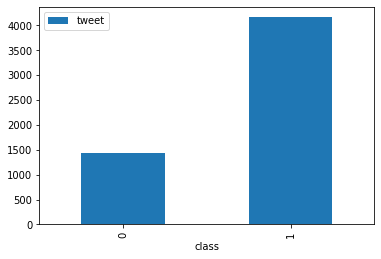

" Alternate way\ndata['class'].value_counts().plot(kind='bar')\nplt.show()\n"

In [154]:
# Check for unbalanced data set

print("Class count: ")
print(data["class"].value_counts())
data.groupby('class').count().plot(kind='bar')
plt.show()
''' Alternate way
data['class'].value_counts().plot(kind='bar')
plt.show()
'''



In [155]:
tweets = data['tweet'].to_numpy()
y = data['class'].to_numpy()

tweets = tweets.tolist()
y = y.tolist()

In [156]:
# Tag Removal
removedTagTweets = []
def remove_tags(tweets):
  for tweet in tweets:
    removedTagTweets.append(re.sub('@\S*', '', tweet))
  return removedTagTweets

tweets = remove_tags(tweets)

In [157]:
# URL Removal
removedUrlTweets = []
def remove_urls(tweets):
  for tweet in tweets:
    removedUrlTweets.append(re.sub('http\S+', '', tweet))
  return removedUrlTweets

tweets = remove_urls(tweets)

In [158]:
# Lower Case Conversion
lowerTweets = []
def convert_to_lower(tweets):
  for tweet in tweets:
    lowerTweets.append(tweet.lower())
  return lowerTweets

tweets = convert_to_lower(tweets)

In [159]:
# Stop word removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the set of stop words the first time
import nltk
nltk.download('stopwords')
nltk.download('punkt')

noStopWordTweets = []
def remove_stopwords(tweets):

  stop_words = set(stopwords.words('english')) # Set improves performance
  
  for tweet in tweets:  
    word_tokens = word_tokenize(tweet) 
    filtered_tweet = [word for word in word_tokens if not word in stop_words] 
    filteredTweetString = ' '.join(word for word in filtered_tweet)
    noStopWordTweets.append(filteredTweetString)
    #print(tweet)
    #print(filtered_tweet)    
    #print (filteredTweetString)
  return noStopWordTweets

tweets = remove_stopwords(tweets)

print(tweets)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


["! ! ! rt woman n't complain cleaning house . & amp ; man always take trash ...", '`` momma said pussy cats inside doghouse ``', '`` -simplyaddictedtoguys woof woof hot scally lad', '`` woof woof hot soles', "`` lemmie eat oreo & amp ; dishes . '' one oreo ? lol", '`` eggplant emoji doe ? `` say looked like scream lmao', '`` baby monkey bathtime awwwwe ! soooo adorable !', "`` queer '' gaywad", "`` alsarabsss '' hes beaner smh tell hes mexican", "`` 're fucking gay , blacklisted hoe '' holding # tehgodclan anyway", "`` baseball season win . # yankees '' love started", "`` 'm early bird 'm night owl , 'm wise worms . ''", "`` overdosing heavy drugs n't sound bad tonight . '' pussy shit every day .", '`` pit bulls photographed lovely fairy tale creatures *are* fairy tale creatures .', "`` long lakers trash , could careless . 's real. '' . cc : hahaha", "`` `` play soccer , cheat girls , wear khaki coloured cargos '' haircut & # 128514 ; yup", "`` n't ghetto ... ..it 's smart 'm idc", '`

In [160]:
# Character removal
unwatedChars = '''()-[]{};:'"\,<>./@#$%^&*_~1234567890'''
def remove_unwanted_characters(tweets):
  cleanTweets = []
  for tweet in tweets:
    for punc in list(unwatedChars):
      tweet = tweet.replace(punc,'')
    cleanTweets.append(tweet)
  return cleanTweets

tweets = remove_unwanted_characters(tweets)

In [161]:
# Lemmatization
'''
import spacy
nlp = spacy.load('en')

def lemmatize(tweets):
  lemmatizedTweets = []
  for tweet in tweets:
    lemmatizedTweet = []
    for token in nlp(tweet):
      lemmatizedTweet.append(token.lemma_)
    lemmatizedTweetString = ' '.join(word for word in lemmatizedTweet)
    lemmatizedTweets.append(lemmatizedTweetString)
  return lemmatizedTweets

tweets = lemmatize(tweets)
'''

"\nimport spacy\nnlp = spacy.load('en')\n\ndef lemmatize(tweets):\n  lemmatizedTweets = []\n  for tweet in tweets:\n    lemmatizedTweet = []\n    for token in nlp(tweet):\n      lemmatizedTweet.append(token.lemma_)\n    lemmatizedTweetString = ' '.join(word for word in lemmatizedTweet)\n    lemmatizedTweets.append(lemmatizedTweetString)\n  return lemmatizedTweets\n\ntweets = lemmatize(tweets)\n"

In [162]:
# Convert our data from lists to a dataframe
cleanData = zip(y, tweets)
cleanDataDf = pd.DataFrame(cleanData, columns = ['class','tweet']) 
cleanDataDf

,class,tweet
0,1,! ! ! rt woman nt complain cleaning house am...
1,1,`` momma said pussy cats inside doghouse ``
2,1,`` simplyaddictedtoguys woof woof hot scally lad
3,1,`` woof woof hot soles
4,1,`` lemmie eat oreo amp dishes one oreo ? lol
...,...,...
5588,1,know say early bird gets worm puts gummy wor...
5589,0,re niggers
5590,0,re retard hope get type diabetes die sugar ru...
5591,1,ve gone broke wrong heart baby drove redneck ...


In [163]:
# Train / test split with stratify, to ensure same percentage of each class is present in the train and the test set.   
print(tweets[0:20]) 

X_train, X_test, y_train, y_test = model_selection.train_test_split(tweets, y, test_size=0.30, random_state=10, stratify = y)

# --- Tf/idf vectorization of strings
tfidfVec_train = TfidfVectorizer()
X_train_tfidf = tfidfVec_train.fit_transform(X_train)
X_test_tfidf = tfidfVec_train.transform(X_test)

['! ! ! rt woman nt complain cleaning house   amp  man always take trash ', '`` momma said pussy cats inside doghouse ``', '`` simplyaddictedtoguys woof woof hot scally lad', '`` woof woof hot soles', '`` lemmie eat oreo  amp  dishes   one oreo ? lol', '`` eggplant emoji doe ? `` say looked like scream lmao', '`` baby monkey bathtime awwwwe ! soooo adorable !', '`` queer  gaywad', '`` alsarabsss  hes beaner smh tell hes mexican', '`` re fucking gay  blacklisted hoe  holding  tehgodclan anyway', '`` baseball season win   yankees  love started', '`` m early bird m night owl  m wise worms  ', '`` overdosing heavy drugs nt sound bad tonight   pussy shit every day ', '`` pit bulls photographed lovely fairy tale creatures are fairy tale creatures ', '`` long lakers trash  could careless  s real   cc  hahaha', '`` `` play soccer  cheat girls  wear khaki coloured cargos  haircut     yup', '`` nt ghetto  it s smart m idc', '`` wants get nose bad bois  scally  chav  sockfetish  stinking hot sox 

--- Metrics of SVM classifier with kernel='linear'and C = 100 :
recall:  0.8797154273535379
prec:  0.9000721649687253
f1:  0.889192163768435
acc:  0.9177592371871275


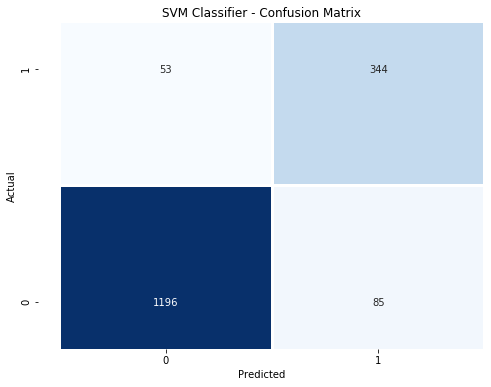

In [164]:
# SVM classifier
modelSVM = svm.SVC(kernel='linear', C = 10)
modelSVM.fit(X_train_tfidf, y_train)

y_pred = modelSVM.predict(X_test_tfidf)

print("--- Metrics of SVM classifier with kernel='linear'and C = 100 :")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
hm = sns.heatmap(confusionMatrix.T, cmap="Blues", linewidths=2, square=False, annot=True, cbar=False, fmt='d',
                 xticklabels=cleanDataDf["class"] .unique(), yticklabels=cleanDataDf["class"].unique())
# Adding margin to figure
bottomMarg, topMarg = hm.get_ylim()
hm.set_ylim(bottomMarg + 0.2, topMarg - 0.2)
leftMargm, rightMarg = hm.get_xlim()
hm.set_xlim(rightMarg + 0.1, leftMargm)

plt.title('SVM Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [165]:
# MultinomialNB classifier
modelNaiveBayes = MultinomialNB()
modelNaiveBayes.fit(X_train_tfidf, y_train)

y_pred = modelNaiveBayes.predict(X_test_tfidf)

print("--- Metrics of Multinomial Naive Bayes classifier: ")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

--- Metrics of Multinomial Naive Bayes classifier: 
recall:  0.7470507874831334
prec:  0.9191841465268278
f1:  0.7898415585084024
acc:  0.8694874851013111


In [166]:
# Logistic Regression classifier
modelLogisticRegression = LogisticRegression()
modelLogisticRegression.fit(X_train_tfidf, y_train)

y_pred = modelLogisticRegression.predict(X_test_tfidf)

print("--- Metrics of Logistic Regression classifier: ")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

--- Metrics of Logistic Regression classifier: 
recall:  0.8068207479736703
prec:  0.9273530268055816
f1:  0.8461507115860678
acc:  0.898092967818832


In [167]:
# Cross-Validation Grid Search
from sklearn import svm
from sklearn.model_selection import GridSearchCV

tfidfVec_dataset = TfidfVectorizer()
dataset_tfidf = tfidfVec_dataset.fit_transform(tweets)

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(dataset_tfidf, y)

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
  print()
print("Best parameters: ",clf.best_params_)

Grid scores on development set:

0.928 (+/-0.022) for {'C': 1, 'kernel': 'linear'}

0.905 (+/-0.022) for {'C': 1, 'kernel': 'rbf'}

0.920 (+/-0.014) for {'C': 10, 'kernel': 'linear'}

0.913 (+/-0.017) for {'C': 10, 'kernel': 'rbf'}

Best parameters:  {'C': 1, 'kernel': 'linear'}


In [168]:
#modelSVM.fit(tweets, y)

joblib.dump(modelSVM, 'hate_speech_model.pkl')
joblib.dump(tfidfVec_train, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [175]:
hate_speech_model = joblib.load( 'hate_speech_model.pkl')
tfidf_vec = joblib.load('tfidf_vectorizer.pkl')

tweets = data['tweet']
y = data['class']

stop_words = set(stopwords.words('english'))  # Set improves performance
unwatedChars = '''()-[]{};:'"\,<>./@#$%^&*_~1234567890'''

pred_tweets= []
for value in tweets.items():
    tweet = value[1]
    #print(tweet)

    tweet = re.sub('@\S*', '', tweet)
    tweet = re.sub('http\S+', '', tweet)
    tweet = tweet.lower()

    word_tokens = word_tokenize(tweet)
    filtered_tweet = [word for word in word_tokens if not word in stop_words]
    tweet = ' '.join(word for word in filtered_tweet)

    for punc in list(unwatedChars):
        tweet = tweet.replace(punc, '')
    '''
    for token in nlp(tweet):
        lemmatizedTweet.append(token.lemma_)
    tweet = ' '.join(word for word in lemmatizedTweet)
    '''
    #print(tweet)
    vectorized_tweet = tfidf_vec.transform([tweet])
    pred = hate_speech_model.predict(vectorized_tweet)
    pred_tweets.append(pred[0])


  

In [177]:
print("f1: ", metrics.f1_score(y.tolist(), pred_tweets, average='macro'))

f1:  0.9663833270688785
